# Face Recognition Project
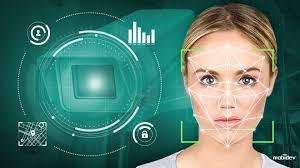

## Introduction
Faceial recognition is a way of identifying or confirming an individual's identity using their face. It can be used to identify people in photos, videos, or in real-time.Facial recognition is in the category of biometric security.

Many people are familiar with face recognition technology through the FaceID used to unlock the phones. Beyond this, it works by matching the faces of people walking past the camera to images of people in a watch list.This procedure tends to operate as follow:

1. Face detection
2. Face analysis
3. Converting the iamge to data
4. Finding match

There are many purpose to the face recognition nowadays all around the globe such as:
+ Unlocking phones
+ Law enforcement
+ Airports and border control
+ Finding missing persons
+ Reduce retail crime
+ Improve retail experiences
+ Banking
+ **Tracking student or worker attendance** etc.


## Phase 1: Face Detection and Data Gathering
We use Opencv package to run live camera. OpenCV was designed for computational efficiency and with a strong focus on real-time applications. So, it’s perfect for real-time face recognition using a camera.

The basic task here is creating a face detecting. The most common way to detect a face, is using "Haar Cascade Classifier". It is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001. 

We don't create our own classifier because opencv already comes with detector and trainer. We want to detect only human face, so we use "haarcascade_frontalface_default.xml" from the "haarcascades" directory in opencv project on Github.

In [1]:
# import all necessarily Packages for the entire project
import cv2
import os
import csv
import numpy as np
from PIL import Image
from datetime import datetime
import pandas as pd

### Capturing face from the camera and store in dataset folder

In [19]:
cam = cv2.VideoCapture(4)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# for each person, enter a numeric face id
face_id = input('\nEnter user id: ')

print('\n[INFO] Initializing face capture....')

# Sample individual face count 
count = 0

while (True):
    ret, img = cam.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)
        count += 1
        # Save captured image into the dataset folder
        cv2.imwrite('dataset/User.' + str(face_id) + '.' + str(count) + '.jpg', gray[y: y+h, x: x+w])

        cv2.imshow('Capturing', img)

    k = cv2.waitKey(50) & 0xff
    if k == 27:
        break
    elif count >= 100: # Record only 30 face of individual
        break

print('\n [INFO] {} faces of user id "{}" have recorded...'.format(count, face_id))
cam.release()
cv2.destroyAllWindows()


[INFO] Initializing face capture....

 [INFO] 101 faces of user id "1" have recorded...


## Phase 2: Train the Recognizer
We use all faces that store in dataset folder to trainer using Opencv function. The result will be store in trainer folder namely "trainer.yml". In this phase we use "pillow" package for processing the image.

We will use as a recognizer, the LBPH (LOCAL BINARY PATTERNS HISTOGRAMS) Face Recognizer, included on OpenCV package.

Note: If Phase 1 have added new data or edit faces of individual this phase 2 must run again to train for new recognizer.

In [20]:
path = 'dataset'

recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# function to get image and label data
def getImageAndLabel(path):

    imagePaths = [os.path.join(path, f) for f in os.listdir(path)]
    faceSample = []
    ids = []

    for imagePath in imagePaths:
        PIL_img = Image.open(imagePath).convert('L') #convert to grayscale
        img_numpy = np.array(PIL_img, 'uint8')

        id = int(os.path.split(imagePath)[-1].split('.')[1])
        faces = detector.detectMultiScale(img_numpy)

        for (x,y,w,h) in faces:
            faceSample.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
    return faceSample, ids

print('\n [INFO] Training faces...')
faces, ids = getImageAndLabel(path)
recognizer.train(faces, np.array(ids))

# save model to the trainer.yml
recognizer.write('trainer/trainer.yml')

print('\n [INFO] {} face (s) trained...'.format(len(np.unique(ids))))


 [INFO] Training faces...

 [INFO] 3 face (s) trained...


## Phase 3: Recognition and Time Tracking
We will capture a fresh face on our camera and if those people had their face captured and trained before, our recognizer will make a “prediction” returning its id and an index, shown how confident the recognizer is with this match. In this case we want to see their names instead of ids, so we make an array storing their name respectively.

Belong side, we also track the name of people who are on the camera along with date and time. We store these data into a single csv file namely "tracker.csv" in the tracker folder.

In [21]:
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('trainer/trainer.yml')
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)


font = cv2.FONT_HERSHEY_SIMPLEX

# to record the data to a csv file name "tracker.csv"
def track(name, confidence): 
    with open('tracker/tracker.csv', 'a', encoding= 'UTF8') as f:
        track_rec = csv.writer(f)
        track_rec.writerow([name, datetime.now().strftime('%Y-%m-%d'), datetime.now().strftime('%H:%M'), confidence])

        f.close()
# to verify the data before record to csv
def check_csv(filename) : 
    df = pd.read_csv(filename)
    
    today = datetime.now().strftime('%Y-%m-%d')
    today_df = df[df['Date'] == today]

    name = list(today_df['Name'].unique())

    return name

#iniciate id counter
id = 0

# names related to ids: example ==> Marcelo: id=1,  etc
names = ['None', 'Nath', 'Chhunheang', 'Nary'] 

# Initialize and start realtime video capture

cam = cv2.VideoCapture(4)
cam.set(3, 640) # set video widht 640
cam.set(4, 480) # set video height 480

# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)

while True:

    ret, img = cam.read()

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 3,
        minSize = (int(minW), int(minH)),
       )

    for(x,y,w,h) in faces:

        cv2.rectangle(img, (x - 5,y -5), (x+w+5,y+h+5), (0,255,0), 2)

        id, confidence = recognizer.predict(gray[y:y+h,x:x+w])

        # Check if confidence is less than 56 ==> "0" is perfect match 
        if (confidence < 60): # 100 checks all faces as it has id in dataset and no one are unknown
            id = names[id]
            confidence = "  {0}%".format(round(100 - confidence))

            check_name = check_csv('tracker/tracker.csv')
            if id not in check_name: #write person who face the camera and also be known
                track(id, confidence)
        else:
            id = "unknown"
            confidence = ''
        
        cv2.putText(img, (str(id) + str(confidence)), (x+5,y-5), font, 1, (255,255,255), 2)
        # cv2.putText(img, str(confidence), (x+5,y+h-5), font, 1, (255,255,0), 1)  
    
    cv2.imshow('camera',img) 

    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break

# Do a bit of cleanup
# print("\n [INFO] Exiting Program and cleanup stuff")
print(check_csv('tracker/tracker.csv'))
cam.release()
cv2.destroyAllWindows()

['Nath']


## Record in CSV file

In [22]:
df = pd.read_csv('tracker/tracker.csv')

print(df)

         Name        Date   Time Accurate
0        Nath  2022-07-08  16:11      NaN
1  Chhunheang  2022-07-08  16:11      NaN
2        Nath  2022-07-09  11:57      NaN
3        Nath  2022-07-11  09:26      NaN
4  Chhunheang  2022-07-11  13:48      NaN
5        Nath  2022-07-14  08:27      51%
6        Nath  2022-07-15  14:22      NaN
7  Chhunheang  2022-07-15  14:26      50%
8        Nary  2022-07-15  15:29      55%
9        Nath  2022-07-16  09:00      41%
